# Dynamic Programming - Group 'Lost in Optimization' - Main python notebook

Install dependencies and set magics:

In [1]:
%load_ext autoreload
%autoreload 2

#%pip install EconModel
#%pip install ConSav
#%pip install quantecon

import time
import numpy as np
import numba as nb
nb.set_num_threads(4) #perhaps set to 8

# load the DurableConsumptionModel module
from DurableConsumptionModel import DurableConsumptionModelClass

## Initial solve of the models

Set amount of periods:

In [2]:
T = 60

Solve model with VFI:

In [3]:
model_vfi = DurableConsumptionModelClass(name='example_vfi',par={'solmethod':'vfi','T':T,'do_print':False})
model_vfi.precompile_numba() # solve with very coarse grids
model_vfi.solve()
model_vfi.simulate()

Traceback (most recent call last):
  File "c:\Users\olive\anaconda3\lib\site-packages\numba\core\types\misc.py", line 69, in literal
    ctor = Literal.ctor_map[ty]
KeyError: <class 'type'>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\olive\OneDrive - Københavns Universitet\KUonedriveOW\7. semester\DyProg\LostInOptimization\ConsumptionSavingNotebooks-master\DurableConsumptionModel\DurableConsumptionModel.py", line 391, in solve
    last_period.solve(t,sol,par)
  File "c:\Users\olive\anaconda3\lib\site-packages\numba\core\dispatcher.py", line 420, in _compile_for_args
    return_val = self.compile(tuple(argtypes))
  File "c:\Users\olive\anaconda3\lib\site-packages\numba\core\dispatcher.py", line 965, in compile
    cres = self._compiler.compile(args, return_type)
  File "c:\Users\olive\anaconda3\lib\site-packages\numba\core\dispatcher.py", line 125, in compile
    status, retval = self._compile_cached(args, ret

KeyboardInterrupt: 

Solve model with NVFI:

In [ ]:
model_nvfi = DurableConsumptionModelClass(name='example_nvfi',par={'solmethod':'nvfi','T':T,'do_print':False})
model_nvfi.precompile_numba() # solve with very coarse grids
model_nvfi.solve()
model_nvfi.simulate()
model_nvfi.save()

Solve model with NEGM:

In [3]:
model_negm = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm','T':T,'do_print':False})
model_negm.precompile_numba() # solve with very coarse grids
model_negm.solve()
model_negm.simulate()
#model_negm.save()

In [4]:
model_negm.simulate()

[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.67 0.67 0.67
 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67
 0.67 0.67 0.67]


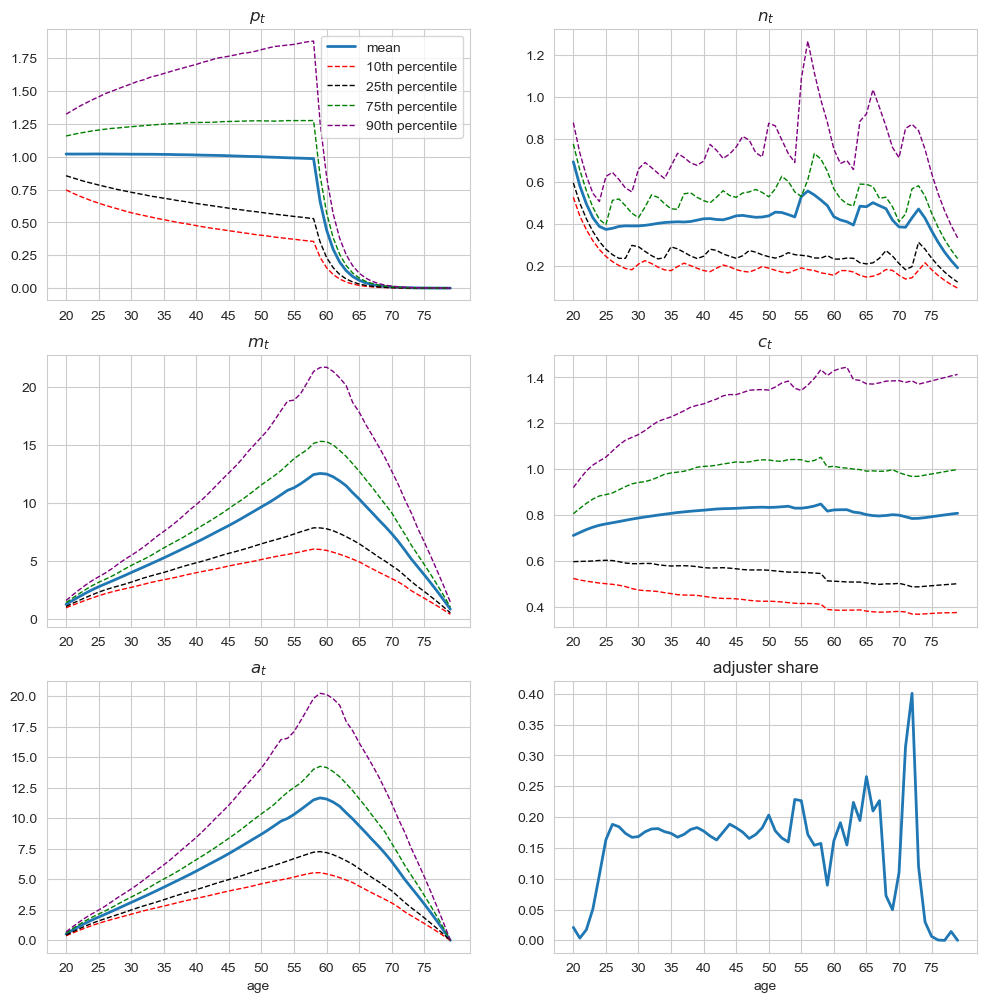

In [5]:
model_negm.lifecycle()

Different versions of beta:

Now possible to compare solutions:

In [ ]:
from figs import lifecycle_compare
lifecycle_compare(model_negm,'negm',model_nvfi,'nvfi')

In [ ]:
model_negm.lifecycle()

## Timing the model solution methods

### Timing function

In [4]:
def run(name = 'baseline',
        rep = 5, # set to 5 in the paper
        load = False,
        solmethod = 'negm',
        updpar = {},
        do_simple_wq = False,
        do_print = False):
    
    # a. create model
    par = {'solmethod':solmethod,'do_print':do_print,'do_simple_wq':do_simple_wq,**updpar}
    model = DurableConsumptionModelClass(name=name,load=load,par=par)
    
    # b. run
    if load == False:
        
        model.precompile_numba()        
        
        # ii. best of three
        best_time = np.inf
        for it in range(rep):
            
            model.solve()
            total_time = np.sum(model.par.time_w+model.par.time_keep+model.par.time_adj)
            
            if total_time < best_time:
            
                best_time = total_time
                time_w = model.par.time_w.copy()
                time_keep = model.par.time_keep.copy()
                time_adj= model.par.time_adj.copy()
            
            print(f'{it}: total time = {total_time:.2f}')
                
        # iii. collect infomation
        model.simulate(do_euler_error=True,do_utility=True)
        model.par.time_w = time_w.copy()
        model.par.time_keep = time_keep.copy()
        model.par.time_adj= time_adj.copy()
        model.save()
            
    # c. print progress
    print('')    
    model.print_analysis()        
    model.checksum(simple=True)
    print('')
    
    return model

### Settings

In [5]:
models = dict()

basename = 'results'
T = 2
base = dict()
base['T'] = T

### Timings

In [6]:
models['negm']  = run(name=f'{basename}', solmethod='negm', updpar=base)

0: total time = 0.16
1: total time = 0.14
2: total time = 0.15
3: total time = 0.15
4: total time = 0.15

Name: results (solmethod = negm)
Grids: (p,n,m,x,a) = (50,50,100,100,100)
Timings:
 total: 0.1
     w: 0.1
  keep: 0.0
   adj: 0.0
Utility: -1.829548
Euler errors:
     total: -3.91 (-4.30,-3.67)
   keepers: -3.93 (-4.29,-3.62)
 adjusters: -3.91 (-4.30,-3.67)
Moments:
 adjuster share: 0.482
         mean c: 1.301
          var c: 0.060
         mean d: 0.258
          var d: 0.004

checksum, inv_v_keep: 1.17120668
checksum, inv_v_adj: 1.25615215



In [7]:
models['nvfi']  = run(name=f'{basename}', solmethod='nvfi', updpar=base)

0: total time = 0.46
1: total time = 0.46
2: total time = 0.45
3: total time = 0.45
4: total time = 0.45

Name: results (solmethod = nvfi)
Grids: (p,n,m,x,a) = (50,50,100,100,100)
Timings:
 total: 0.4
     w: 0.1
  keep: 0.4
   adj: 0.0
Utility: -1.829548
Euler errors:
     total: -3.58 (-4.53,-3.00)
   keepers: -3.53 (-4.48,-2.95)
 adjusters: -3.58 (-4.53,-3.00)
Moments:
 adjuster share: 0.482
         mean c: 1.301
          var c: 0.060
         mean d: 0.258
          var d: 0.004

checksum, inv_v_keep: 1.17305144
checksum, inv_v_adj: 1.25615230



In [9]:
models['vfi']   = run(name=f'{basename}', solmethod='vfi', updpar=base)

0: total time = 10.69
1: total time = 11.53
2: total time = 10.68
3: total time = 11.76
4: total time = 11.70

Name: results (solmethod = vfi)
Grids: (p,n,m,x,a) = (50,50,100,100,100)
Timings:
 total: 10.7
     w: 0.0
  keep: 10.1
   adj: 0.6
Utility: -1.829488
Euler errors:
     total: -3.84 (-4.84,-3.19)
   keepers: -3.85 (-4.86,-3.24)
 adjusters: -3.84 (-4.84,-3.19)
Moments:
 adjuster share: 0.482
         mean c: 1.302
          var c: 0.060
         mean d: 0.257
          var d: 0.004

checksum, inv_v_keep: 1.17307212
checksum, inv_v_adj: 1.25473012



### Time tables

In [ ]:
import tabs
main_models = [models['negm'],models['nvfi'],models['vfi']]
tabs.all(main_models,speedup=True)